In [1]:
#hidden cell to be executed BEFORE the presentation
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import dftpy
from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional
from dftpy.formats import io
from dftpy.math_utils import ecut2nr
from dftpy.time_data import TimeData
from dftpy.optimization import Optimization
from dftpy.mpi import sprint
from IPython.lib.display import YouTubeVideo
from IPython.display import IFrame
from ase.visualize import view
PP_list = {'Al': 'Al_lda.oe01.recpot'}
import fortecubeview

<center>
    <h1>Adaptive embedding</h1>
    <h3>tackles chemical processes in molecular condensed phases</h3>
<center>
<br>
    <br>
<table>
  <tr>
      <td><p><h1>Michele Pavanello</h1></p><p style="color:blue">@MikPavanello</p><p><h2>Rutgers University-Newark</h2></p></td>
      <td><img src="figures/logos/run.png" width=250 height=250 /></td>
  </tr>
  <tr>
    <td></td>
    <td> http://prg.rutgers.edu</td>
  </tr>
</table>

#### ACS Spring National Meeting -- March 27, 2023


# Acknowledgements

<table>
  <tr>
      <td><p><h3>Students</h3></p><p>Dr Xuecheng Shao</p><p>Dr Xin Chen</p><p>Alina Umerbekova</p><p>Jessica Martinez</p><p>Valeria Rios </p></td>
      <td><img src="figures/prg_pics/prg_2023.png" width=800 /></td>
  </tr>
</table>

Funding: NSF, DOE, MolSSI, ACS-PRF, Rutgers

# We aim to model `The Real World`
<table>
    <tr>
      <td><h3>Photocatalyst</h3></td>
        <td><h3>Catalytic nanoparticles</h3></td>
  </tr>
  <tr>
      <td><img src="figures/science/photocatalyst.png" height=500 /></td>
      <td><img src="figures/science/catalyst.png" height=500 /></td>
  </tr>
    <tr>
        <td>Chem. Comm., 43, 6551 (2009)</td>
        <td>PCCP, 21, 15080 (2019)</td>
    </tr>
</table>   

# (some of the) Available electronic structure methods
<br>
<center>
    <img src="figures/science/electronic_structure.png" width=1600 />
</center>

# An option: Orbital-free DFT (OF-DFT)
<br>

<center>
<ul>
    <li><p><b>OF-DFT</b> is like DFT but <b>with only one orbital</b>!</p></li>
    <li><p>The variational function is the electron density <u>only</u></p> 
        <p>$$n(\mathbf{r})=N |\psi(\mathbf{r})|^2$$</p></li>
    <li><p>The energy functional is a pure functional of $n(\mathbf{r})$</p>
        <p>$$E[n]=T_s[n]+ E_H[n]+E_{xc}[n]+\int n(\mathbf{r}) v_{ext}(\mathbf{r}) d \mathbf{r} $$</p></li>
    <li><p>Ground state is found by direct minimization</p>
        <p>$$n_0(\mathbf{r})=\text{argmin}_n\left[ E[n]-\mu \left(\int n(\mathbf{r})d\mathbf{r}-N\right)\right]$$</p></li>
</ul>
</center>

<div class="alert alert-block alert-success"><center><b>Opportunity:</b> No need to diagonalize any matrix!</center></div>
<div class="alert alert-block alert-danger"><center><b>Problem:</b> $T_s[n]$ exists, but it is not known...</center></div>




### OF-DFT's $T_s[n]$: (semi)local and nonlocal functionals
<br>
<center>
    <img src="figures/science/local_nonlocal.png" width=1600 />
<p>Wenhui Mi, MP JCP (2018) • Wenhui Mi, MP PRB (2019) • Xuecheng Shao, WM, MP PRB (2021)
Xuecheng Shao, WM, MP JPCL (2021) • Xuecheng Shao, WM, MP JCTC (2021) • Wenhui Mi, MP JPCL (2020)</p>
    </center>

<center><div class="alert alert-block alert-danger">
    Ok... but it is really much faster than KS-DFT?
</div> 
    </center>

# OF-DFT in practice
### How hard is it to run an OF-DFT simulation?
1. Generate a model system
2. Set up an OF-DFT simulation engine
3. Pick a $T_s[n]$, <b>noninteracting kinetic energy density functional</b> (KEDF)
4. Define "total energy" and <b>minimize</b> $E[n]$ $\to n(\mathbf{r})$!!

1. Generate a model system: bulk Al (cubic cell) with ASE

In [2]:
from ase.build import bulk
atoms = bulk('Al', 'fcc', a=4.05, cubic=True)
ions = Ions.from_ase(atoms)
view(ions, viewer='ngl')

2. Set up an OF-DFT simulation with `DFTpy`

In [3]:
IFrame('http://dftpy.rutgers.edu', width=1400, height=400)

In [4]:
grid = DirectGrid(lattice=ions.cell, nr=[32,32,32])
PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list)
rho_ini = DirectField(grid=grid)
rho_ini[:] = ions.get_ncharges()/ions.cell.volume
HARTREE = Functional(type='HARTREE')
XC = Functional(type='XC',name='LDA')

setting key: Al -> Al_lda.oe01.recpot


3. Pick a noninteracting kinetic energy density functional (KEDF), $T_s[n]$. Such as:
 
<br>

 - TF+vW: 
 $$T_{FvW}[n] = \int C_{TF} ~n^{5/3}(\mathbf{r})~ d\mathbf{r} + \int \frac{\nabla n^{1/2}(\mathbf{r})\cdot \nabla n^{1/2}(\mathbf{r})}{2} ~d\mathbf{r}$$

<br>

- Wang-Teter: 
$$T_{WT}[n] = C_{TF} \int n^{5/6}(\mathbf{r}) \omega_{WT}(|\mathbf{r}-\mathbf{r'}|) n^{5/6}(\mathbf{r'})d\mathbf{r} $$

In [5]:
#KE = Functional(type='KEDF',name='x_TF_y_vW')
KE = Functional(type='KEDF',name='WT')

4. Define "total energy" and minimize $E[n]$

In [6]:
%%time 
evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
opt = Optimization(EnergyEvaluator=evaluator, optimization_options = {'econv' : 1e-6}, optimization_method = 'TN')
rho = opt.optimize_rho(guess_rho=rho_ini)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       2.692153511701E+00      2.692154E+00    7.877729E-01    1       1       3.479123E-02    
1       2.444205307834E+00      -2.479482E-01   7.686545E-02    13      1       2.020311E-01    
2       2.440109792965E+00      -4.095515E-03   7.515780E-03    9       1       3.283811E-01    
3       2.439477503092E+00      -6.322899E-04   4.686242E-04    15      1       5.107253E-01    
4       2.439453878115E+00      -2.362498E-05   2.643558E-05    11      1       6.484013E-01    
5       2.439451898616E+00      -1.979499E-06   2.162498E-06    13      1       8.172450E-01    
6       2.439451794385E+00      -1.042311E-07   1.713146E-07    9       1       9.300921E-01    
7       2.439451780872E+00      -1.351308E-08   2.172083E-08    13      1       1.089084E+00    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.2927354326401062
Chemical potential (eV)  : 7.96573610050

# How does OF-DFT compare with KS-DFT?

<h4 style="text-align: center;">Let's run a Quantum ESPRESSO calculation of the <b>same system</b> using <i>QEpy</i></h4>

In [7]:
IFrame('http://qepy.rutgers.edu', width=1400, height=400)

In [8]:
from qepy.driver import Driver

In [9]:
driver=Driver('qe_in.in', comm=None, iterative=True, logfile='qepy.out')
print("Number of K points: ", driver.get_number_of_k_points())
print("Energy Cutoff: ", driver.get_ecutrho()/4, "Ry")
print("# of grid points: ", driver.get_number_of_grid_points())

Number of K points:  172
Energy Cutoff:  40.0 Ry
# of grid points:  [32 32 32]


### `QEPy`

#### First diagonalize

In [14]:
%%time
driver.diagonalize()

CPU times: user 5.62 s, sys: 257 ms, total: 5.87 s
Wall time: 5.63 s


#### Then mix and check for convergence

In [15]:
%%time
if not driver.check_convergence: 
    driver.mix()
    print("SCF Error: ",driver.get_scf_error())

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 23.8 µs


<center><div class="alert alert-block alert-danger">
    KS-DFT is two$+$ order of magnitude slower than semilocal OF-DFT!
</div></center>

### Let's look at the quality of the density

In [16]:
rhoks=driver.data2field(driver.get_density())
drho=rhoks-rho
drho.write('drho.cube',ions=ions)
print("Density error: ",np.abs(drho).integral()/2)

Density error:  0.05071000523843701


In [17]:
sumlevel=0.75
print("Isosurface value: ","{:.2E}".format((1.0-sumlevel)*np.max(np.abs(drho))))

Isosurface value:  7.75E-04


In [19]:
fortecubeview.plot(cubes=['./drho.cube'],sumlevel=sumlevel);

Reading 1 cube file


HTML(value='\n        <style>\n           .jupyter-widgets-output-area .output_scroll {\n                heigh…

interactive(children=(Select(description='Cube files:', options=('./drho.cube',), value='./drho.cube'), Output…

# OF-DFT with nonlocal $T_s[n]$ can approach semiconductor surfaces!

<center>
    <p style="font-size:100%; text-align:center;">Shao, Mi & Pavanello, Phys. Rev. B <b>104</b>, 045118 (2021)</p>
    <br>
    <img src="figures/science/ofdft_surfaces.png" width=1800 />
    <div class="alert alert-block alert-success">Excellent results for difficult semiconductors and metals!</div>
</center>

# What else can OF-DFT do?
<br>
<center>
    <p style="font-size:100%; text-align:center;"> J. Phys. Chem. Lett. <b>12</b>, 4134 (2021) &#x25C6; WIREs: Comp. Mol. Sci. <b>11</b>, e1482 (2021)</p>
    <br>
    <img src="figures/science/ofdft_showoff.png" width=1600 />
    <div class="alert alert-block alert-success">How about optical spectra and dynamics? $\ldots$ talk to me after the session!</div>
</center>

# OF-DFT han an Achilles heel...
<br>
<center>
<img src="figures/science/periodic_all.png" width=1100 />
</center>

# `Local` pseudopotentials only available for selected atoms
<br>
<center>
<img src="figures/science/periodic_ofdft.png" width=1100 />
</center>

<center>
    <h1>We can't put all of our eggs in the OF-DFT basket</h1>
    <br>
    We need alternative methods to approach the mesoscale.
    <br>
</center>

<center>
    Methods need to:
    <br>
    <ul>
        <li> <b>First:</b> scale computationally at most as $\mathcal{O}[Nln(N)]$ (like OF-DFT)</li>
        <li> <b>Second:</b> approach realistic system sizes without using an entire supercomputer (no need for exascale)!</li>
        <li> <b>Third:</b> be accurate </li>
    </ul>
</center>

<center>
  <h2>Shall we try Subsystem DFT?</h2>
</center>

# Subsystem DFT (sDFT) - Theory

<div class="alert alert-block alert-warning">
    <p><b>Idea:</b></p>
    <ul>
        <li>Split system into (smaller) subsystems: $n(\mathbf{r})=\sum_I n_I(\mathbf{r})$</li>
        <li>Use KS-DFT <b>or</b> OF-DFT for the subsystems</li>
        <li><p>Energy is split in <i>additive</i> and <i>non-additive</i> terms:</p><p>$$E[n]\equiv E[\{n_I\}]=\sum_I E[n_I] + E^{nadd}[\{n_I\}]$$</p></li>
        <li><p>The nonadditive energy given by:</p><p>$$E^{nadd}[\{n_I\}] = E[n] - \sum_IE[n_I] \to \tilde T_s^{nadd}[\{n_I\}]+E_{Hxc}^{nadd}[\{n_I\}]+ \text{Coulomb interactions between subsystems}$$</p></li>
    </ul>
</div>
<div class="alert alert-block alert-danger">
<b>Problem:</b> Must use approximate non-additive kinetic energy, $T_s^{nadd}[\{n_I\}]$
</div>
<div class="alert alert-block alert-success">
    <b>Opportunity #1:</b> We can use <i>accurate non-local</i> $T_s^{nadd}[\{n_I\}]$, previously developed for OF-DFT!
</div>
<div class="alert alert-block alert-success">
    <b>Opportunity #2:</b> We can use <i>non-local</i> pseudopotentials! $\to$ access to entire Periodic Table!
</div>

# Subsystem DFT (sDFT) implementations:


In [20]:
IFrame('http://eqe.rutgers.edu', width=1400, height=400)

In [21]:
IFrame('http://edftpy.rutgers.edu', width=1400, height=400)

# Subsystem DFT (sDFT) - Timings
<br>
<center>
<img src="figures/science/sdft_timings.png" width=1300 />
</center>
<ul>
    <li> Comp. Phys. Comm. <b>269</b>, 108122 (2021)</li>
    <li> Int. J. Quantum Chem. <b>117</b> e25401 (2017)</li>
    <li> J. Phys. Chem. Lett. <b>10</b> 7554 (2019)</li>
</ul>
<div class="alert alert-block alert-success">
    <b>Good News: eQE and eDFTpy sDFT timings are exactly right!</b>
</div>

# sDFT for weakly interacting subsystems
<br>

<p style="font-size:100%; text-align:center;">Deviation against CCSD(T)/CBS for the S66 test set</p>

<table>
    <tr>
        <td>
            <center>
                <img src="figures/science/sdft_s66.png" width=700 />
            </center>
        </td>
        <td>&nbsp;&nbsp;&nbsp;&nbsp;</td>
        <td>
            <center>
                <img src="figures/science/S66_comparisons.png" width=700 />
            </center>
        </td>
    </tr>
    <tr>
        <td>
            <ul>
                <li> Comp. Phys. Comm. <b>269</b>, 108122 (2021)</li>
                <li> J. Chem. Theory Comput. <b>17</b> 3455 (2021)</li>
                <li> J. Phys. Chem. Lett. <b>11</b> 272 (2020)</li>
            </ul>
        </td>
        <td>
        </td>
        <td>
            <ul>
                <li> J. Chem. Theory Comput. <b>7</b> 2427 (2011)</li>
            </ul>
        </td>
    </tr>
    </tr>
</table>
<div class="alert alert-block alert-success">
    <b>sDFT approaches weakly interacting subsystems correctly and almost as accurately as nonlocal KS-DFT</b>
</div>

# sDFT for strongly interacting subsystems
<br>
When subsystems come close and interact strongly
<br>
<center>
     <img src="figures/science/merging_splitting.png" width=800 />
    <br>
    Even the best non-additive functionals are <b>not good enough for this!</b>
</center>

<div class="alert alert-block alert-warning">
    <b> <center> We need an "adaptive" sDFT method</center></b>
</div>

<ul style="text-align: left; font-size: 100%; line-height:90%;margin-top: 0; margin-bottom: 0;">
    <li> We should be able to "split" and "merge" subsystems along a dynamics or relaxation</li>
    <li> Do so <i>automatically</i>, i.e., determine automatically a subsystem's:</li>
    <ul>
        <li> computational setting: basis set, smearing, etc$\ldots$</li>
        <li> charge, spin multiplicity, etc $\ldots$</li>
        <li> redefine MPI communicators on-the-fly (yes it's all done in parallel)</li>
    </ul>
</ul>
<div class="alert alert-block alert-danger">
    <b> <center> Might it be too hard?</center></b>
</div>

# Example: a Diels-Alder reaction
<br>
<center>
<img src="figures/science/diels-alder.png" width=1400 />
</center>

<div class="alert alert-block alert-warning">
    <b>Price to pay</b>: inter-atomic cut-off radius (in parentheses)
</div>

# "Adaptive" sDFT: let's watch it in action!

<table>
    <tr>
        <td>
            <center>NaCl in water $\to$ Na$^+_{\rm (aq)}$ + Cl$^-_{\rm (aq)}$</center>    
            <ul>
                <li> Na and Cl slowly dissociate to their solvated ions</li>
                <li>100+ water molecules, Na$^+$ and Cl$^-$ in a box</li>
                <li> NVT ab-initio dynamics for a few picoseconds</li>
                <li> H$_2$O molecules <b>interact strongly</b> with both ions</li>
            </ul>
        </td>
        <td><img src="figures/science/qr_adaptive.png" width=400 align="right" /></td>
    </tr>
</table>

### In the video: variable # subsystems along AIMD

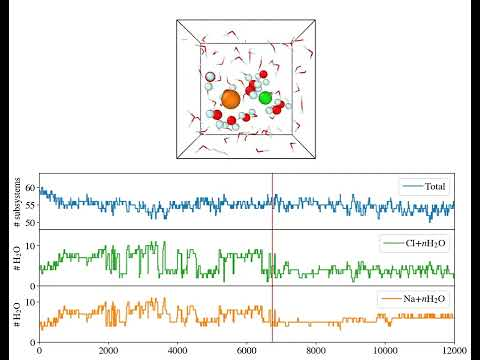

In [22]:
YouTubeVideo('-lmdPHzJfeU', width=750, height=550)

# Group X aqua ions with adaptive sDFT: Ni(II) and Pd(II)
<br>
<center>
    <img src="figures/science/hydration/Complex.png" width=600 align="center" />
    <p>
        <ul>
            <li>Inspect the structure of Ni$^{2+}_{\rm (aq)}$, Pd$^{2+}_{\rm (aq)}$</li>
            <li>Compare with "experiment"</li>
            <li>Use sDFT and a carefully calibrated PBE+U xc functional</li>
        </ul>
    </p>
</center>


# Metal hydration with adaptive sDFT: a meso-shell?

<br>
<center>
<table>
    <tr>
        <td>Ni$^{2+}$ -- Total $G_{Ni}(r)$</td>
        <td>Pd$^{2+}$ -- Metal-Oxygen $G_{Pd-O}(r)$</td>
    </tr>
    <tr>
        <td>
            <img src="figures/science/hydration/Gr-ni_exp.png" width=400 align="center" />
        </td>
        <td>
            <img src="figures/science/hydration/mesoshell.png" width=700 align="center" />
        </td>
    </tr>
    <tr>
        <td>
            <p>Neilson, G. W., and J. E. Enderby<br>"The hydration of Ni$^{2+}$ in aqueous solutions"<br>J. Phys. C <b>11</b>, 15 (1978): L625</p>
        </td>
        <td>
            <p>Bowron, Daniel T., et al. <br>"Axial structure of the Pd (II) aqua ion in solution"<br>J. Am. Chem. Soc.<b>134</b>, 2 (2012): 962-967</p>
        </td>
    </tr>
</table>
    </center>

# Adaptive sDFT: comparison to experiment for Ni(II) and Pd(II)

<br>
<center>
<table>
    <tr>
        <td><b><center>Ni(II) -- Total $G_{Ni}(r)$ and partial $G_{Ni-O}(r)$</center></b></td>
        <td><b><center>Pd(II) -- Total structure factor $S(Q)$</center></b></td>
    </tr>
    <tr>
        <td>
            <img src="figures/science/hydration/ni-total.png" width=850 align="center" />
        </td>
        <td>
            <img src="figures/science/hydration/sq-pd.png" width=1150 align="center" />
        </td>
    </tr>
    <tr>
        <td>
            <ul>
            <li style="color:grey;">Almost quantitative agreement with experiments</li>
            <li>XRay: Powell et al 1989 J. Phys.: Condens. Matter 1 8721; </li>
            <li>N scattering: Nelson et al J. Phys. C 11, 15 L625 (1978)</li>
            </ul>
        </td>
        <td>
            <ul>
            <li style="color:blue;">Better agreement with the experiment compared with the EPSR result of Bowron <i>et al.</i></li>
            </ul>
        </td>
    </tr>
</table>
    </center>

# Axial meso-shell for Pd(II)?
<br>
<table>
    <tr>
        <td><h4 style="text-align:center;"> Bowron et al. $G_{Pd-O}(r)$ result (EPSR)</h4></td>
        <td><h4 style="text-align:center;"> sDFT $G_{Pd-O}(r)$ result</h4></td>
    </tr>
    <tr>
        <td><img src="figures/science/hydration/pd-gr-o_exp.png" width=500 align="center" /></td>
        <td><img src="figures/science/hydration/pd-gr-o.png" width=1000 align="center" /></td>
    </tr>
</table>
<div class="alert alert-block alert-warning">
    <b><center>We see no meso-shell - just a broad second solvation shell</center></b>
</div>
<div class="alert alert-block alert-warning">
    <b><center>...to be continued</center></b>
</div>


<center>
    <h1>The End...</h1>
    <br>
    <br>
    <br>
    <table>
        <tr>
            <td style="text-align:center;"><b>We discussed:</b></td>
            <td style="text-align:center;"><b style="color:red;">We didn't discuss:</b></td>
        </tr>
        <tr>
            <td>
                <ul>
                    <li> Orbital-Free DFT</li>
                    <li> Subsystem DFT</li>
                    <li> Software: DFTpy, QEpy, eDFTpy</li>
                    <li> Adaptive subsystem DFT</li>
                </ul>
            </td>
            <td>
                <ul style="color:red;">
                    <li> Machine learning 1-rdms</li>
                    <li> Orbital-Free TDDFT</li>
                    <li> Subsystem TDDFT </li>
                    <li> "Orbital-Free in Kohn-Sham" embedding</li>
                    <li> Wavefunction-in-DFT methods</li>
                </ul>
            </td>
    </table>
    <br>
    <br>
    <br>
    <h1>Thank you!</h1>
</center>